In [1]:
device = 'mps'


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import tqdm as tqdm


In [77]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((32, 32)),
])

train_dataset = torchvision.datasets.QMNIST('data', train=True, download=True, transform=transforms)
# test_dataset = torchvision.datasets.QMNIST('data', train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training with {len(train_dataset)} samples")
# print(f"Testing with {len(test_dataset)} samples")


Training with 60000 samples


In [127]:
def gradient_penalty(
    discriminator, real: torch.Tensor, fake: torch.Tensor
) -> torch.Tensor:
    alpha = torch.rand(real.size(0), 1, 1, 1).to(real.device)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size()).to(real.device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# DCGAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 4, 2, 0),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Sigmoid(),
        )
                
    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(256, 100, 4, 2, 0),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(100, 1),
        )
    
        
    def forward(self, x):
        return self.layers(x).view(-1)


generator = Generator().to(device)
discriminator = Discriminator().to(device)

optim_g = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.9, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.9, 0.999))


In [128]:
print(f"Generator has {sum(p.numel() for p in generator.parameters() if p.requires_grad):,} parameters")
print(f"Discriminator has {sum(p.numel() for p in discriminator.parameters() if p.requires_grad):,} parameters")


Generator has 1,066,433 parameters
Discriminator has 1,066,633 parameters


In [149]:
optim_g = optim.Adam(generator.parameters(), lr=1e-5, betas=(0.9, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.9, 0.999))


In [150]:
generator.train()
discriminator.train()

with tqdm.tqdm(10, total=10*len(train_loader)) as t:
    for epoch in range(10):
        t.set_description(f"Epoch {epoch}")
        for real, _ in train_loader:
            t.update()
            real = real.to(device)
            noise = torch.randn(real.size(0), 100, 1, 1).to(device)
            
            # Train discriminator
            optim_d.zero_grad()
            fake = generator(noise)
            loss_d = -(discriminator(real).mean() - discriminator(fake).mean()) + gradient_penalty(discriminator, real, fake) * 10
            loss_d.backward()
            optim_d.step()
            
            # Train generator
            if t.n % 4 == 0:
                optim_g.zero_grad()
                loss_g = -discriminator(generator(noise)).mean()
                loss_g.backward()
                optim_g.step()
            
            t.set_postfix_str(f"Loss D: {loss_d.item():.4f} Loss G: {loss_g.item():.4f} Sliced Wisserstein: {(discriminator(real).mean() - discriminator(fake).mean()).item():.4f}")
            
        print(f"Epoch {epoch} Loss D: {loss_d.item()} Loss G: {loss_g.item()}")
        
        with torch.no_grad():
            generator.eval()
            noise = torch.randn(64, 100, 1, 1).to(device)
            fake = generator(noise)
            fake = torchvision.utils.make_grid(fake, nrow=8, normalize=True)
            plt.imshow(fake.permute(1, 2, 0).cpu().numpy())
            plt.show()
            generator.train()


Epoch 0:   9%|▊         | 799/9380 [01:25<15:18,  9.34it/s, Loss D: -1.6979 Loss G: 2.0068 Sliced Wisserstein: 1.8270]


KeyboardInterrupt: 

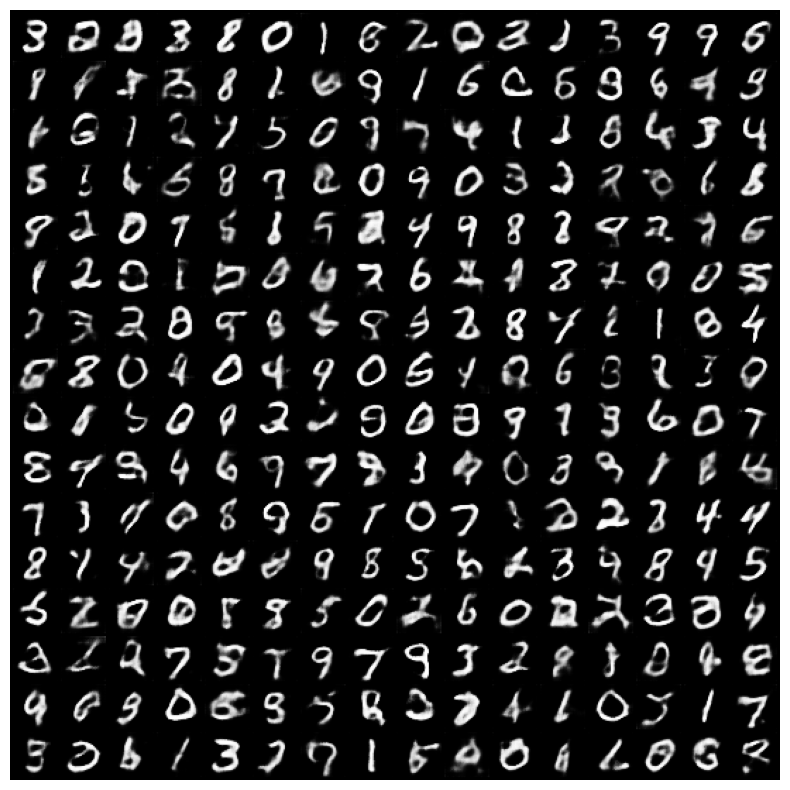

In [151]:
generator.eval()
discriminator.eval()

noise = torch.randn(16**2, 100, 1, 1, device=device)
fake = generator(noise)
plt.figure(figsize=(10, 10))
grid = torchvision.utils.make_grid(fake, nrow=16).clamp(0, 1)
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.show()


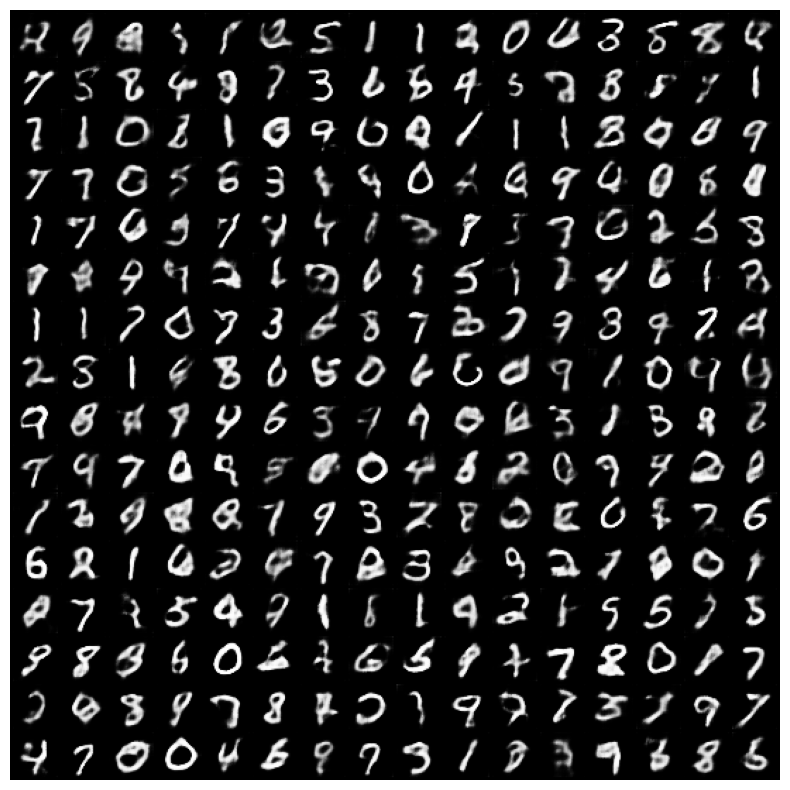

In [152]:
generator.eval()
discriminator.eval()

noise = torch.randn(16**2, 100, 1, 1, device=device)
fake = generator(noise)
plt.figure(figsize=(10, 10))
grid = torchvision.utils.make_grid(fake, nrow=16).clamp(0, 1)
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.show()
